# Research Task - Statewide VRM/VRH by Operator per UZA [#1536](https://github.com/cal-itp/data-analyses/issues/1536)

**Task:**
<br>develop a statewide, analysis presented as a notebook, with an interactive map + a table of statewide VRH and VRM aggregated for each operator in each FTA UZA (and outside of those areas, in each RTPA or county).

**Metrics:** 
<br>total VRM and VRH in a UZA, percent of each metric that is provided by a given operator


**Expected Outputs / Findings:**
<br>notebook portfolio site with a map of all UZAs, with stats that pop up in the tooltip as one mouses over a UZA. Plus a table.

## Migrate initial statewide work from sjcog service anaylsis

In [1]:
import requests
import pandas as pd
from calitp_data_analysis.sql import query_sql
import geopandas as gpd
import gcsfs
import google.auth

credentials, project = google.auth.default()
fs = gcsfs.GCSFileSystem(token=credentials)

pd.set_option('display.max_rows', None)

## Latest Transit Service Intensity (TSI) data
should include operators

In [2]:
# tsi_agency = "gs://calitp-analytics-data/data-analyses/transit_service_intensity/test_tsi_agency_2025-04-16.parquet"
tsi_agency_2 = "gs://calitp-analytics-data/data-analyses/transit_service_intensity/test_tsi_agency_2025-07-16.parquet"

In [3]:
# read in parquet as gdf
tsi_data = gpd.read_parquet(
    tsi_agency_2,
    storage_options={"token": credentials.token},
)

In [4]:
tsi_data.head()

,tract,pop_sq_mi,population,geometry,schedule_gtfs_dataset_key,daily_vrm_miles,daily_vrh_hours
0,06001400100,1174.735672,3120,"POLYGON ((-197090.096 -12468.283, -196909.112 ...",a8d5f90bfd689badb7e1deb041408e96,179.5,2.9
1,06001400100,1174.735672,3120,"POLYGON ((-197090.096 -12468.283, -196909.112 ...",c499f905e33929a641f083dad55c521e,3.3,0.3
2,06001400200,8729.842564,2007,"POLYGON ((-196982.196 -15963.566, -196992.931 ...",8a1405af8da1379acc062e346187ac98,227.6,5.2
3,06001400200,8729.842564,2007,"POLYGON ((-196982.196 -15963.566, -196992.931 ...",c499f905e33929a641f083dad55c521e,388.7,37.7
4,06001400300,11819.185546,5051,"POLYGON ((-197350.929 -16712.642, -197950.200 ...",8a1405af8da1379acc062e346187ac98,227.6,5.2


<Axes: >

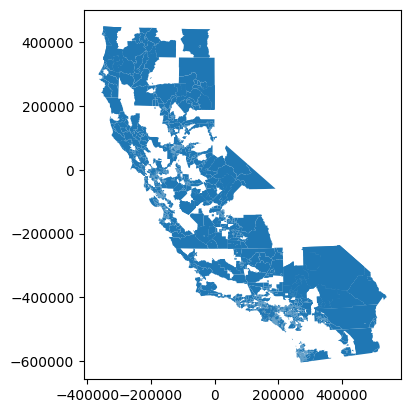

In [5]:
tsi_data.plot()

In [6]:
## Add agency name to table
query_dim_gtfs_datasets = """
SELECT
  key,
  name,
  analysis_name,
  type,
  regional_feed_type
FROM `cal-itp-data-infra.mart_transit_database.dim_gtfs_datasets`
WHERE
  type = "schedule"
"""

gtfs_dataset_names = query_sql(
    query_dim_gtfs_datasets,
    as_df = True
)

gtfs_dataset_names= gtfs_dataset_names.rename(columns ={
    "name":"gtfs_dataset_name",
    "type":"gtfs_type"
})

In [7]:
gtfs_dataset_names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2693 entries, 0 to 2692
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   key                 2693 non-null   object
 1   gtfs_dataset_name   2693 non-null   object
 2   analysis_name       251 non-null    object
 3   gtfs_type           2693 non-null   object
 4   regional_feed_type  305 non-null    object
dtypes: object(5)
memory usage: 105.3+ KB


In [34]:
# test merge 
tsi_names = tsi_data.merge(
    gtfs_dataset_names,
    left_on = "schedule_gtfs_dataset_key",
    right_on = "key",
    how = "left",
    indicator = True
)

In [36]:
display(
    tsi_names.info(),
    tsi_names["_merge"].value_counts(),
    tsi_names["regional_feed_type"].value_counts(dropna=False),
    tsi_names.head()
)

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 10273 entries, 0 to 10272
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   tract                      10273 non-null  object  
 1   pop_sq_mi                  10273 non-null  float64 
 2   population                 10273 non-null  int64   
 3   geometry                   10273 non-null  geometry
 4   schedule_gtfs_dataset_key  10273 non-null  object  
 5   daily_vrm_miles            10273 non-null  float64 
 6   daily_vrh_hours            10273 non-null  float64 
 7   key                        10273 non-null  object  
 8   gtfs_dataset_name          10273 non-null  object  
 9   analysis_name              0 non-null      object  
 10  gtfs_type                  10273 non-null  object  
 11  regional_feed_type         2082 non-null   object  
 12  _merge                     10273 non-null  category
dtypes: category(1), float64

None

both          10273
left_only         0
right_only        0
Name: _merge, dtype: int64

None                      8191
Regional Subfeed          1904
Combined Regional Feed     178
Name: regional_feed_type, dtype: int64

,tract,pop_sq_mi,population,geometry,schedule_gtfs_dataset_key,daily_vrm_miles,daily_vrh_hours,key,gtfs_dataset_name,analysis_name,gtfs_type,regional_feed_type,_merge
0,06001400100,1174.735672,3120,"POLYGON ((-197090.096 -12468.283, -196909.112 ...",a8d5f90bfd689badb7e1deb041408e96,179.5,2.9,a8d5f90bfd689badb7e1deb041408e96,Bear Schedule,None,schedule,None,both
1,06001400100,1174.735672,3120,"POLYGON ((-197090.096 -12468.283, -196909.112 ...",c499f905e33929a641f083dad55c521e,3.3,0.3,c499f905e33929a641f083dad55c521e,Bay Area 511 AC Transit Schedule,None,schedule,Regional Subfeed,both
2,06001400200,8729.842564,2007,"POLYGON ((-196982.196 -15963.566, -196992.931 ...",8a1405af8da1379acc062e346187ac98,227.6,5.2,8a1405af8da1379acc062e346187ac98,Bay Area 511 BART Schedule,None,schedule,Regional Subfeed,both
3,06001400200,8729.842564,2007,"POLYGON ((-196982.196 -15963.566, -196992.931 ...",c499f905e33929a641f083dad55c521e,388.7,37.7,c499f905e33929a641f083dad55c521e,Bay Area 511 AC Transit Schedule,None,schedule,Regional Subfeed,both
4,06001400300,11819.185546,5051,"POLYGON ((-197350.929 -16712.642, -197950.200 ...",8a1405af8da1379acc062e346187ac98,227.6,5.2,8a1405af8da1379acc062e346187ac98,Bay Area 511 BART Schedule,None,schedule,Regional Subfeed,both


In [42]:
tsi_names["gtfs_dataset_name"].sort_values().unique().tolist()

['Alhambra Schedule',
 'Amador Schedule',
 'Amtrak Schedule',
 'Anaheim Resort Schedule',
 'Anaheim Resort Schedule v2',
 'Antelope Valley Transit Authority Schedule',
 'Arcadia Schedule',
 'Artesia Schedule',
 'B-Line Schedule',
 'Baldwin Park Schedule',
 'Banning Pass Schedule',
 'Basin Transit GMV Schedule',
 'Bay Area 511 AC Transit Schedule',
 'Bay Area 511 ACE Schedule',
 'Bay Area 511 Angel Island-Tiburon Ferry Schedule',
 'Bay Area 511 BART Schedule',
 'Bay Area 511 Caltrain Schedule',
 'Bay Area 511 Capitol Corridor Schedule',
 'Bay Area 511 Commute.org Schedule',
 'Bay Area 511 County Connection Schedule',
 'Bay Area 511 Dumbarton Express Schedule',
 'Bay Area 511 Emery Express Schedule',
 'Bay Area 511 Emery Go-Round Schedule',
 'Bay Area 511 Fairfield and Suisun Transit Schedule',
 'Bay Area 511 Golden Gate Ferry Schedule',
 'Bay Area 511 Golden Gate Park Shuttle Schedule',
 'Bay Area 511 Golden Gate Transit Schedule',
 'Bay Area 511 MVGO Schedule',
 'Bay Area 511 Marin Sch

In [43]:
# CA Counties
county_url="https://caltrans-gis.dot.ca.gov/arcgis/rest/services/CHboundary/County_Boundaries/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson"

county_map=gpd.read_file(
    county_url,
    storage_options={"token": credentials.token}
)


In [12]:
# CA state UZA map
uza_url="https://caltrans-gis.dot.ca.gov/arcgis/rest/services/CHboundary/Adjusted_Urban_Area/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson"
uza_map=gpd.read_file(
    uza_url,
    storage_options={"token": credentials.token}
)


# urban areas in San Joaquin coutny
uza_list =[
    "Stockton, CA",
    "Tracy--Mountain House, CA",
    "Manteca, CA",
    "Lodi, CA"
]


In [ ]:
uza_map.explore()

In [ ]:
tsi_data.explore()

In [16]:
ca_uza_tsi_overlay = uza_map.overlay(tsi_data.to_crs("EPSG:4326"),how='intersection')

In [38]:
uza_tsi_names = uza_map.overlay(tsi_names.to_crs("EPSG:4326"),how='intersection')

In [ ]:
ca_uza_tsi_overlay.explore()
# looking at Davis. Part of tract x0401 on the east end of Davis appears after the overlay, but is attributed the full 53 vrm. (overestimated)


<Axes: >

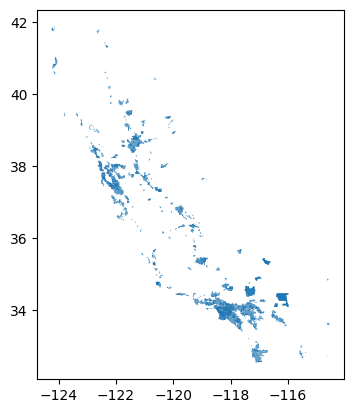

In [39]:
uza_tsi_names.plot()

# How much of the census tract is in the UZA map? 
and vise-versa

In [21]:
# vise vera
uza_tract = uza_map.to_crs("EPSG:4326").overlay(tsi_data.to_crs("EPSG:4326"),how='intersection')
tract_uza = tsi_data.to_crs("EPSG:4326").overlay(uza_map.to_crs("EPSG:4326"),how='intersection')

/tmp/ipykernel_842/121543251.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  uza_tract["geometry"].area.sum() == tract_uza.geometry.area.sum()


True

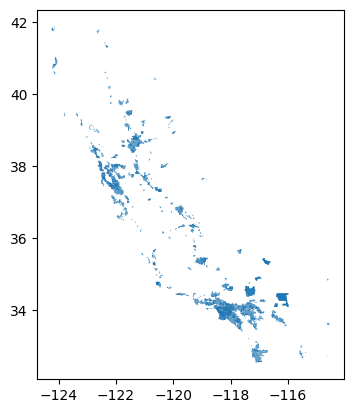

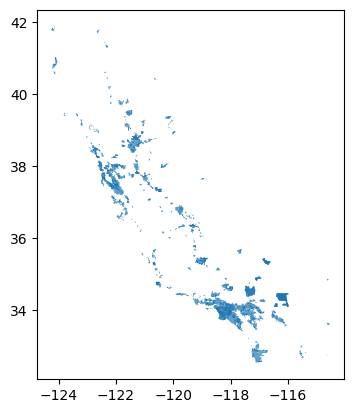

In [24]:
uza_tract.plot(),
tract_uza.plot(),
# compare area
uza_tract["geometry"].area.sum() == tract_uza.geometry.area.sum()

# How many gtfs keys are in each uza?

## What is the vrm/vrh per gtfs key, for each UZA?

In [33]:
ca_uza_tsi_overlay.groupby([
    "NAME",
]).agg({
    "schedule_gtfs_dataset_key":"nunique",
    "daily_vrm_miles":"sum",
    "daily_vrh_hours":"sum"
}).reset_index()

,NAME,schedule_gtfs_dataset_key,daily_vrm_miles,daily_vrh_hours
0,"Alpine, CA",1,2323.2,103.2
1,"Antioch, CA",8,26023.7,1778.3
2,"Arcata, CA",2,4100.7,451.5
3,"Arroyo Grande--Grover Beach--Pismo Beach, CA",2,3502.3,172.7
4,"Arvin, CA",1,213.1,0.2
5,"Auburn, CA",4,1538.0,36.4
6,"Avenal, CA",1,324.3,0.0
7,"Bakersfield, CA",3,40009.6,2881.5
8,"Barstow, CA",4,29179.2,1461.9
9,"Big Bear, CA",1,6772.6,354.3


# Where can I get California Census Block geometry data?

**Holding off on this for now. May not need if we can run the UZA map through TSI natively**

- can get CA census block data from Redistricting Data (PL 94-171)
- state› county› tract› block
- https://api.census.gov/data/2020/dec/pl?get=NAME&for=block:*&in=state:06&in=county:*&in=tract:*&key=YOUR_KEY_GOES_HERE"

- can get CA shape files from TIGER/Line Geodatabases?
https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2022.html#list-tab-790442341"

# Can i change Eric's initial work to get census block instead of tract?
Per meeting with Eric, we can refactor TSI scripts to accept more geographies than census tract. See:
- `data-analyses/transit_service_intensity/update_vars.py`
- `data-analyses/transit_service_intensity/define_tsi_segments.py`

1. define_tsi_segments read in census tract gdf.
2. gets schedule shape trips from segment speed utils
3. get borders from parquet
4. get scheduled trip data for all ops at a specific date
5. make tsi segments from the schedule shapes with `overlay_tracts_borders` function:
    - reads tracts gdf, border gdf, 
7. 

What is `tsi_segs` from `define_tsi_segments.py`?

In [5]:
from calitp_data_analysis.gcs_geopandas import GCSGeoPandas
gcsgp = GCSGeoPandas()
GCS_PATH = "gs://calitp-analytics-data/data-analyses/transit_service_intensity/"
ANALYSIS_DATE = "2025-07-16"

In [6]:
tsi_segs = gcsgp.read_parquet(f'{GCS_PATH}tsi_segments_{ANALYSIS_DATE}.parquet')

In [11]:
tsi_segs.head()

,shape_array_key,tract,tract_1,pop_sq_mi_1,population_1,tract_2,pop_sq_mi_2,population_2,intersection_id,geometry,border,start,tsi_segment_id,tsi_segment_meters
0,0007036d1a4d64a1eafe861c02f69515,06067000700,None,NaN,NaN,None,NaN,NaN,None,"LINESTRING (-130628.254 63957.340, -130608.731...",False,POINT (-130628.254 63957.340),06067000700,351.895675
1,0007036d1a4d64a1eafe861c02f69515,06067000700,None,NaN,NaN,None,NaN,NaN,None,"LINESTRING (-130998.575 63670.528, -130979.792...",False,POINT (-130998.575 63670.528),06067000700,603.476130
2,0007036d1a4d64a1eafe861c02f69515,06067000800,None,NaN,NaN,None,NaN,NaN,None,"LINESTRING (-130559.065 63102.568, -130615.793...",False,POINT (-130559.065 63102.568),06067000800,1021.591310
3,0007036d1a4d64a1eafe861c02f69515,06067001101,None,NaN,NaN,None,NaN,NaN,None,"LINESTRING (-130297.654 63837.052, -130294.602...",False,POINT (-130297.654 63837.052),06067001101,1374.729363
4,0007036d1a4d64a1eafe861c02f69515,06067001101,None,NaN,NaN,None,NaN,NaN,None,"LINESTRING (-129986.076 62897.730, -130028.399...",False,POINT (-129986.076 62897.730),06067001101,608.494488


In [13]:
display(
    tsi_segs.info(),
    tsi_segs[tsi_segs["tract"]=="06067000800"].explore()
)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 178215 entries, 0 to 178214
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   shape_array_key     178215 non-null  object  
 1   tract               92479 non-null   object  
 2   tract_1             85736 non-null   object  
 3   pop_sq_mi_1         85736 non-null   float64 
 4   population_1        85736 non-null   float64 
 5   tract_2             85736 non-null   object  
 6   pop_sq_mi_2         85736 non-null   float64 
 7   population_2        85736 non-null   float64 
 8   intersection_id     85736 non-null   object  
 9   geometry            178215 non-null  geometry
 10  border              178215 non-null  bool    
 11  start               178215 non-null  geometry
 12  tsi_segment_id      178215 non-null  object  
 13  tsi_segment_meters  178215 non-null  float64 
dtypes: bool(1), float64(5), geometry(2), object(6)
memory usage:

None